---
title: "test run -- 'are political conversations meaning-agnostic?'"
author: "ezou"
date: "2025-01-15"
format:
  html:
    embed-resources: true
    toc: true
    toc-depth: 3
    number-sections: true
    code-fold: false
execute:
  echo: true
  warning: false
---

# imports 
### BERT
Notice that we're using BERT (https://research.google/pubs/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/) here.

### link
You can download and test different words here: https://github.com/emzou/testrun

In [1]:
import pandas as pd 
import numpy as np
import json
from collections import Counter
import spacy
from itertools import chain 
from collections import OrderedDict
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from scipy.stats import entropy
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stopwordlist = stopwords.words('english')
from transformers import AutoTokenizer
from transformers import pipeline
unmasker = pipeline("fill-mask", model="bert-base-uncased")

[nltk_data] Downloading package stopwords to /Users/easy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/easy/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your m

# reading in the data
### Data collected 
here: https://github.com/emzou/testrun/blob/main/retrieve_data.py

### API
We won't be using the 4Chan API to process the real data, but the data format of 4pleb's data dumps is the same (2023 example here: https://archive.org/details/4plebs-org-data-dump-2024-01)

### Collection
Collected on 01-08-2024 11:27AM using the 4Chan API, which only collects live information, which returned 8245 separate threads between January 5-8 2025 (so, a very small range)

In [2]:
#processing functions 
def transform_dict(data):
    if "text" in data:  
        match = re.search(r'>>(\d+)', data["text"]) 
        if match:
            data["replyto"] = match.group(1)  
            data["text"] = re.sub(r'>>\d+', '', data["text"]).strip() 
    return data
def convert_key_to_string(dict_list, key):
    for d in dict_list:
        if key in d and isinstance(d[key], int):
            d[key] = str(d[key])  # Convert the value to a string
    return dict_list
# functions to get the threads with the word we are interested in 
def get_no_if_text_in_string(lst, string):
    pattern = rf'\b{re.escape(string)}\b'
    return [d['no'] for d in lst if 'text' in d and re.search(pattern, d['text'])]

In [3]:
# read in the datasets 
## the full dictionary w/ all post data
with open ('sets/cleanarchive.json', 'r') as file: 
    data = json.load(file)
v = list(chain.from_iterable(data)) 
a = [transform_dict(x) for x in v]
a = [x for x in a if isinstance(x, dict)]
b = convert_key_to_string(a, 'no')

## a list of the post's ID in thread order. each list represents a thread
with open('nested_list.txt', 'r') as f:
    me_loaded = json.load(f)
me_flat = [item for sublist in me_loaded for item in sublist]
me_moop = [[str(x) for x in l] for l in me_flat]

In [4]:
def get_text_from_id(a_id_number):
    the_text = [x['text'] for x in b if x['no'] == a_id_number]
    return the_text

def get_full_and_mentions(a_word):
    lista = get_no_if_text_in_string(a, a_word)
    list1 = [str(x) for x in lista]
    def get_consecutive_lists(a_word):
        return [
            sublist for sublist in me_moop
            if isinstance(sublist, list) and any(
                list1[i] in sublist and list1[i + 1] in sublist
                for i in range(len(list1) - 1)
            )
        ]
    def get_word_ids(the_thread):
        return [item for item in the_thread if item in list1]
    
    def filter_lists_by_last_id(data):
        return list({lst[-1]: lst for lst in sorted(data, key=len, reverse=True) if lst}.values())  
    conseclist = get_consecutive_lists(a_word)
    filtered_conseclist = filter_lists_by_last_id(conseclist)
    threads_and_id = list(map(get_word_ids, filtered_conseclist))
    data = list(zip(filtered_conseclist, threads_and_id))
    df = pd.DataFrame(data, columns=['Full Threads', 'Has Words'])
    df['Word_Pos'] = df.apply(lambda x: [x['Full Threads'].index(m) for m in x['Has Words']], axis=1)
    df['Convo_Length'] = df['Full Threads'].apply(len)
    df['ID'] = df.index
    df['sentences'] = df['Has Words'].apply(lambda x: [get_text_from_id(str(m)) for m in x])
    return df

def preprocess_sentences(sentences, target_word):
    def normalize(text):
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table).lower()
    normalized_target = normalize(target_word)
    masked_sentences = []
    for sentence in sentences:
        words = sentence.split()
        regex = rf'\b{re.escape(normalized_target)}\b'
        if re.search(regex, normalize(" ".join(words))):
            masked_sentence = " ".join("[MASK]" if re.fullmatch(regex, normalize(word)) else word for word in words)
            masked_sentences.append(masked_sentence)
    return masked_sentences

def analyze_top1_and_similarity(masked_sentences, stopwords, max_length=512, top_k=10):
    tokenizer = unmasker.tokenizer
    top1_candidates = []
    sentence_candidates = []
    pos_similarity_scores = []
    similarity_scores = []  
    for sentence in masked_sentences:
        if "[MASK]" not in sentence:
            continue
        tokenized = tokenizer.encode(sentence, add_special_tokens=True)
        if len(tokenized) > max_length:
            continue
        predictions = unmasker(sentence)
        if not (isinstance(predictions, list) and all(isinstance(pred, dict) for pred in predictions)):
            continue
        valid_candidates = [
            pred for pred in predictions 
            if pred['token_str'].strip() not in string.punctuation and pred['token_str'].lower() not in stopwords
        ]
        filtered_candidates = {pred['token_str']: pred['score'] for pred in valid_candidates}
        sentence_candidates.append(filtered_candidates)    
        if filtered_candidates:
            top1_word = max(filtered_candidates, key=filtered_candidates.get)
            top1_candidates.append(f"{top1_word}: {filtered_candidates[top1_word]}")
            
            # Determine POS of the top1_word and the [MASK] position
            doc = nlp(sentence.replace("[MASK]", top1_word))
            masked_index = [i for i, token in enumerate(doc) if token.text == top1_word]
            if masked_index:
                masked_token_pos = doc[masked_index[0]].pos_
                pos_scores = [
                    pred['score'] for pred in predictions
                    if nlp(pred['token_str'])[0].pos_ == masked_token_pos
                ]
                pos_similarity_scores.append(max(pos_scores) if pos_scores else 0)
        else:
            top1_candidates.append("No valid prediction")
            pos_similarity_scores.append(0)
    for i in range(len(sentence_candidates)):
        for j in range(i + 1, len(sentence_candidates)):
            dist_i = sentence_candidates[i]
            dist_j = sentence_candidates[j]
            common_words = set(dist_i.keys()).intersection(set(dist_j.keys()))
            if not common_words:
                similarity_scores.append(0)
                continue
            score_diff = np.mean([abs(dist_i[word] - dist_j[word]) for word in common_words])
            similarity_scores.append(1 - score_diff)
    avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
    avg_pos_similarity = np.mean(pos_similarity_scores) if pos_similarity_scores else 0
    return {
        "Top-1 Candidates": top1_candidates,
        "Average Similarity": avg_similarity,
        "Average POS Similarity": avg_pos_similarity
    }

In [5]:
def word_to_df(the_word):
    dataf = get_full_and_mentions(the_word)
    dataf['maskedsent'] = dataf['sentences'].apply(lambda x: [preprocess_sentences(m, the_word) for m in x])
    dataf['mask'] = dataf['maskedsent'].apply(lambda x: list(chain.from_iterable(x))) 
    dataf['Similarity'] = dataf['mask'].apply(lambda x: analyze_top1_and_similarity(x, stopwordlist))
    dataf['Sim_Score'] = dataf['Similarity'].apply(lambda x: x['Average Similarity'])
    dataf['POS_Sim_Score'] = dataf['Similarity'].apply(lambda x: x['Average POS Similarity'])
    return dataf

# what the dataframe shows
##
We have a database of conversation threads, which show the lifespan of every conversation (Every conversation begins with the Opening Post, and travels the replies all the way to the last reply (which didn't receive any replies))  

##
Input a word, we search for all the conversation threads that have the word show up. We filter the conversation threads to only include threads where the word appears at least twice. 



##
The word is 'masked' (literally, by the string [MASK]). 
- If the sentence is: "I enjoy watching the TV show House." and the word you're interested in is "House", the sentence now looks like "I enjoy watching the TV show [MASK]"

##
We ask BERT to give its best guesses for what word 'MASK' is, returning a list of candidate words and its confidence level for each candidate word. 
- We also use spaCy to guess the part of speech of the 'MASK' word. 
- We get a 'similarity score' and a 'part of speech similarity score' on how close the model's guesses of the word in each sentence is to each other. (Importantly, not whether the model was right or not, but whether its guesses were similar)

##   
We also collected the 'position' that each word appeared in the conversation thread based on its index. We also collect how long the conversation went on after the words show up on the thread.

In [6]:
fulldf = word_to_df("woman")

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [7]:
#view df 
fulldf

,Full Threads,Has Words,Word_Pos,Convo_Length,ID,sentences,maskedsent,mask,Similarity,Sim_Score,POS_Sim_Score
0,"[493485835, 493485195, 493484848, 493482005]","[493485835, 493485195]","[0, 1]",4,0,"[[I agree I literally never said that, I sai...","[[I agree I literally never said that, I said ...","[I agree I literally never said that, I said t...",{'Top-1 Candidates': ['people: 0.1100629866123...,0.986069,0.068819
1,"[493465403, 493465268, 493464900, 493464762, 4...","[493465403, 493465268, 493454834]","[0, 1, 18]",29,1,[[>converted by a woman >lets her better his q...,[[>converted by a [MASK] >lets her better his ...,[>converted by a [MASK] >lets her better his q...,{'Top-1 Candidates': ['woman: 0.23987351357936...,0.803247,0.258764
2,"[493540659, 493540293, 493540200, 493539816, 4...","[493540659, 493540200]","[0, 2]",15,2,[[>And the ease with which he divested himself...,[[>And the ease with which he divested himself...,[>And the ease with which he divested himself ...,{'Top-1 Candidates': ['woman: 0.78796994686126...,0.872913,0.851513
3,"[493498180, 493495860, 493495252, 493494412, 4...","[493498180, 493491291]","[0, 4]",12,3,[[4/ _bk1.htm%23First >Some say Sabaoth has th...,"[[], [>Perhaps the cry of “Hyes Attes! Hyes At...",[>Perhaps the cry of “Hyes Attes! Hyes Attes!”...,{'Top-1 Candidates': ['woman: 0.66045790910720...,0.000000,0.660458
4,"[493419991, 493419756, 493419641, 493419421, 4...","[493419991, 493419756]","[0, 1]",9,4,[[>You're never getting your foreskin back >Yo...,[[>You're never getting your foreskin back >Yo...,[>You're never getting your foreskin back >You...,{'Top-1 Candidates': ['man: 0.2606106996536255...,0.915907,0.320440
...,...,...,...,...,...,...,...,...,...,...,...
161,"[493489091, 493488911]","[493489091, 493488911]","[0, 1]",2,161,"[[I was 28, and trying to figure out how to ge...","[[], []]",[],"{'Top-1 Candidates': [], 'Average Similarity':...",0.000000,0.000000
162,"[493643702, 493643557]","[493643702, 493643557]","[0, 1]",2,162,"[[>I have never met a woman Ftfy], [I have nev...","[[>I have never met a [MASK] Ftfy], [I have ne...","[>I have never met a [MASK] Ftfy, I have never...",{'Top-1 Candidates': ['good: 0.035287994891405...,0.000000,0.238734
163,"[493601585, 493600013]","[493601585, 493600013]","[0, 1]",2,163,[[the liberals will never get elected anytime ...,[[the liberals will never get elected anytime ...,[the liberals will never get elected anytime s...,"{'Top-1 Candidates': ['No valid prediction', '...",0.000000,0.090640
164,"[493655950, 493655791]","[493655950, 493655791]","[0, 1]",2,164,[[I already have a woman I've never had a prob...,[[I already have a [MASK] I've never had a pro...,[I already have a [MASK] I've never had a prob...,{'Top-1 Candidates': ['feeling: 0.471853792667...,0.000000,0.048756


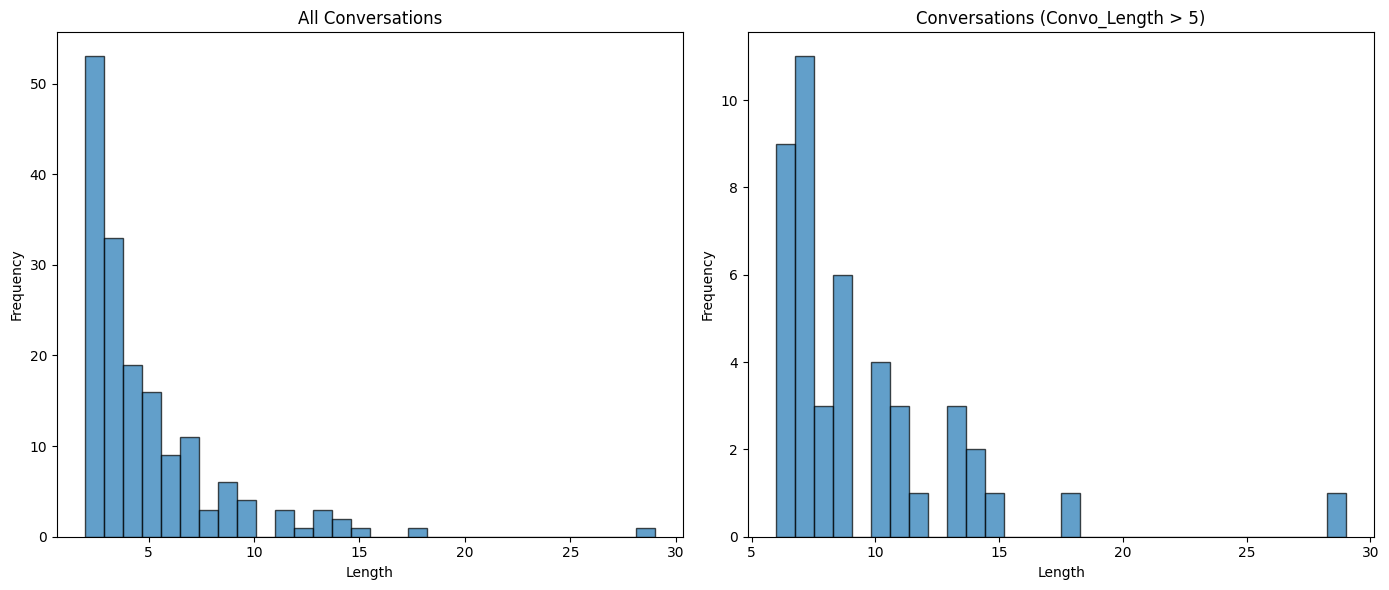

In [8]:
# look at the overall conversation length distributions with conversations in which ...the word... appeared 
def plot_side_by_side(data):
    fiona_counts = [len(x) for x in data['Full Threads']]
    filtered_data = data[data['Convo_Length'] > 5]
    filtered_fiona_counts = [len(x) for x in filtered_data['Full Threads']]
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(fiona_counts, bins=30, edgecolor='black', alpha=0.7)
    plt.title('All Conversations')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(filtered_fiona_counts, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Conversations (Convo_Length > 5)')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_side_by_side(fulldf)

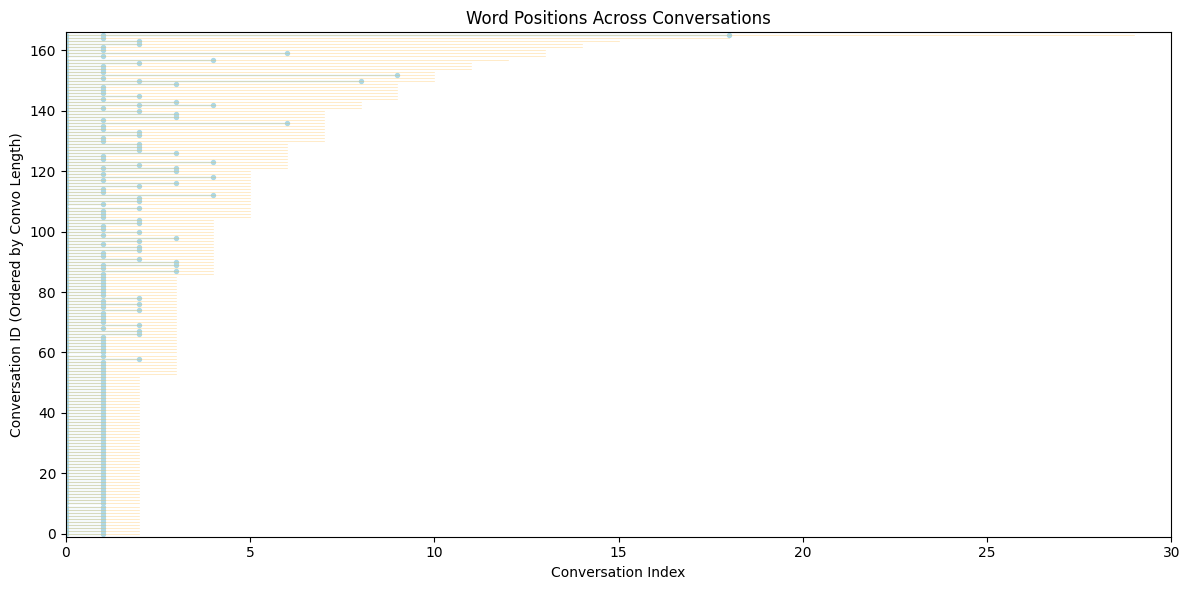

In [9]:
# look at where each word occurrence... occurred in the entire conversation thread
def visualize_word_positions(dataframe):
    dataframe = dataframe.sort_values(by='Convo_Length', ascending=True).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(12, 6))
    for idx, row in dataframe.iterrows():
        word_positions = row['Word_Pos']
        convo_length = row['Convo_Length'] + 1
        if len(word_positions) > 1:
            ax.plot(word_positions, [idx] * len(word_positions), color='lightblue', alpha=0.6, linewidth=1)
        ax.plot([0, convo_length - 1], [idx, idx], color='orange', alpha=0.3, linewidth=0.5)
        ax.scatter(word_positions, [idx] * len(word_positions), color='lightblue', s=8)
    ax.set_xlim(0, dataframe['Convo_Length'].max() + 1)
    ax.set_ylim(-1, len(dataframe))
    ax.set_xlabel('Conversation Index')
    ax.set_ylabel('Conversation ID (Ordered by Convo Length)')
    ax.set_title('Word Positions Across Conversations')
    plt.tight_layout()
    plt.show()

visualize_word_positions(fulldf)

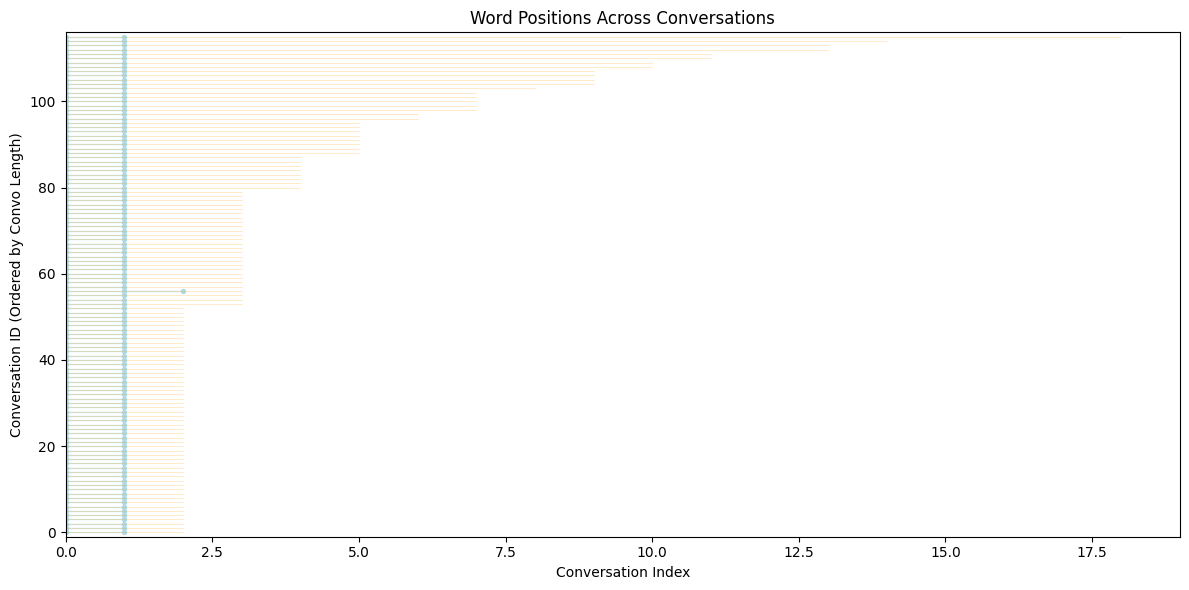

In [10]:
# only look at conversations where ... the word... appeared consecutively (in direct conversation)
def is_consecutive(numbers):
    return all(b - a == 1 for a, b in zip(numbers, numbers[1:]))
da = fulldf[fulldf['Word_Pos'].apply(is_consecutive)]
visualize_word_positions(da)

In [11]:
#view da
da

,Full Threads,Has Words,Word_Pos,Convo_Length,ID,sentences,maskedsent,mask,Similarity,Sim_Score,POS_Sim_Score
0,"[493485835, 493485195, 493484848, 493482005]","[493485835, 493485195]","[0, 1]",4,0,"[[I agree I literally never said that, I sai...","[[I agree I literally never said that, I said ...","[I agree I literally never said that, I said t...",{'Top-1 Candidates': ['people: 0.1100629866123...,0.986069,0.068819
4,"[493419991, 493419756, 493419641, 493419421, 4...","[493419991, 493419756]","[0, 1]",9,4,[[>You're never getting your foreskin back >Yo...,[[>You're never getting your foreskin back >Yo...,[>You're never getting your foreskin back >You...,{'Top-1 Candidates': ['man: 0.2606106996536255...,0.915907,0.320440
6,"[493426163, 493425843, 493425346, 493425216, 4...","[493426163, 493425843]","[0, 1]",18,6,"[[it does, to lay with a man as you would lay ...","[[it does, to lay with a man as you would lay ...","[it does, to lay with a man as you would lay w...",{'Top-1 Candidates': ['man: 0.2481773197650909...,0.000000,0.248177
7,"[493644707, 493641149, 493640771, 493628486, 4...","[493644707, 493641149]","[0, 1]",5,7,[[>You're not entitled to sex with a woman at ...,[[>You're not entitled to sex with a [MASK] at...,[>You're not entitled to sex with a [MASK] at ...,{'Top-1 Candidates': ['man: 0.5526390671730042...,0.928478,0.459630
8,"[493402288, 493399994, 493398514, 493389986, 4...","[493402288, 493399994]","[0, 1]",5,8,[[The first example is adultery. Its a cut off...,[[The first example is adultery. Its a cut off...,[The first example is adultery. Its a cut off ...,{'Top-1 Candidates': ['woman: 0.89872688055038...,0.980488,0.921860
...,...,...,...,...,...,...,...,...,...,...,...
161,"[493489091, 493488911]","[493489091, 493488911]","[0, 1]",2,161,"[[I was 28, and trying to figure out how to ge...","[[], []]",[],"{'Top-1 Candidates': [], 'Average Similarity':...",0.000000,0.000000
162,"[493643702, 493643557]","[493643702, 493643557]","[0, 1]",2,162,"[[>I have never met a woman Ftfy], [I have nev...","[[>I have never met a [MASK] Ftfy], [I have ne...","[>I have never met a [MASK] Ftfy, I have never...",{'Top-1 Candidates': ['good: 0.035287994891405...,0.000000,0.238734
163,"[493601585, 493600013]","[493601585, 493600013]","[0, 1]",2,163,[[the liberals will never get elected anytime ...,[[the liberals will never get elected anytime ...,[the liberals will never get elected anytime s...,"{'Top-1 Candidates': ['No valid prediction', '...",0.000000,0.090640
164,"[493655950, 493655791]","[493655950, 493655791]","[0, 1]",2,164,[[I already have a woman I've never had a prob...,[[I already have a [MASK] I've never had a pro...,[I already have a [MASK] I've never had a prob...,{'Top-1 Candidates': ['feeling: 0.471853792667...,0.000000,0.048756


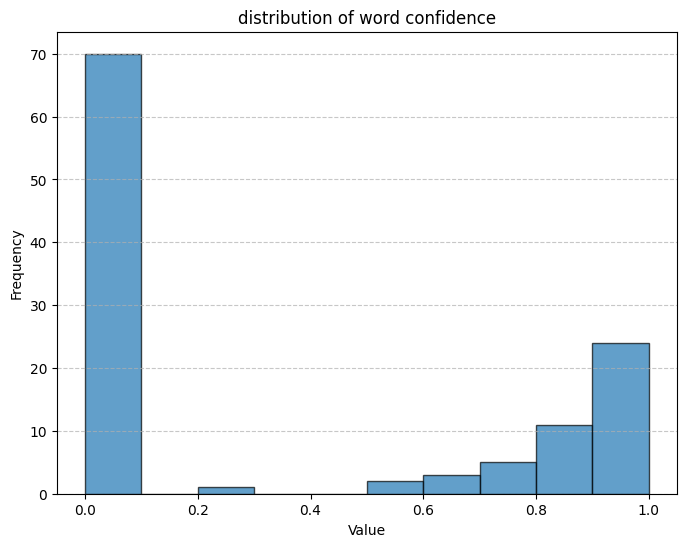

In [12]:
# look at the distribution of similarity scores in consecutive appearances
def plot_overall_sim_score(data):
    filtered_data = [x for x in data['Sim_Score']]
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_data, bins=10, edgecolor='black', alpha=0.7)
    plt.title("distribution of word confidence")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_overall_sim_score(da)

/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_11501/253171063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da['Convo_After'] = da.apply(lambda row: row['Convo_Length'] - row['Word_Pos'][-1], axis=1)


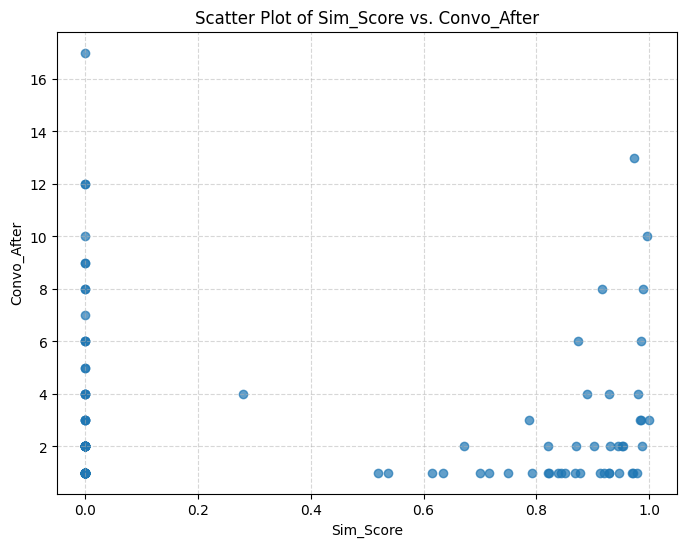

In [13]:
# look at the relationship between similarity score and the length of the conversation that followed the interaction 
da['Convo_After'] = da.apply(lambda row: row['Convo_Length'] - row['Word_Pos'][-1], axis=1)
plt.figure(figsize=(8, 6))
plt.scatter(da['Sim_Score'], da['Convo_After'], alpha=0.7)
plt.title('Scatter Plot of Sim_Score vs. Convo_After')
plt.xlabel('Sim_Score')
plt.ylabel('Convo_After')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

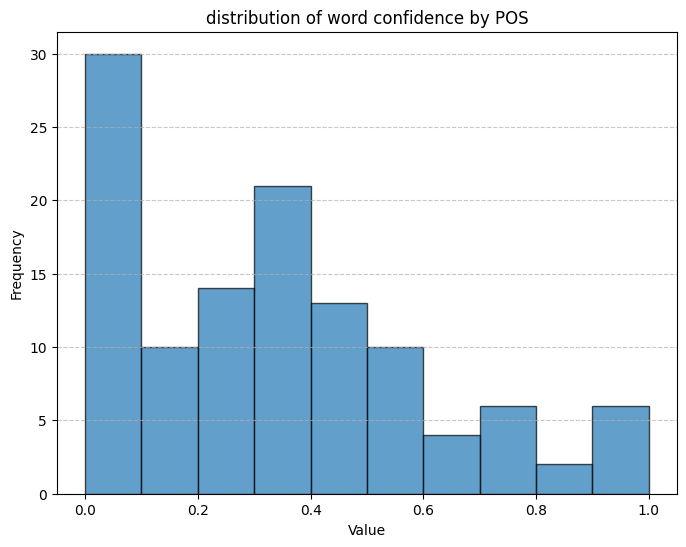

In [14]:
# look at the distribution of POS similarity scores in consecutive appearances
def plot_overall_possim_score(data):
    filtered_data = [x for x in data['POS_Sim_Score']]
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_data, bins=10, edgecolor='black', alpha=0.7)
    plt.title("distribution of word confidence by POS")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_overall_possim_score(da)

/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_11501/2536110429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da['Convo_After'] = da.apply(lambda row: row['Convo_Length'] - row['Word_Pos'][-1], axis=1)


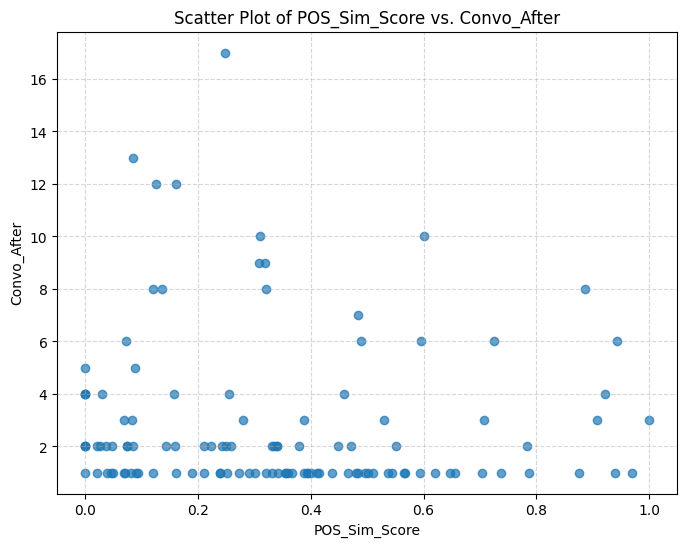

In [15]:
# look at the relationship between pos similarity score and the length of the conversation that followed the interaction 
da['Convo_After'] = da.apply(lambda row: row['Convo_Length'] - row['Word_Pos'][-1], axis=1)
plt.figure(figsize=(8, 6))
plt.scatter(da['POS_Sim_Score'], da['Convo_After'], alpha=0.7)
plt.title('Scatter Plot of POS_Sim_Score vs. Convo_After')
plt.xlabel('POS_Sim_Score')
plt.ylabel('Convo_After')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()